# Modified MNIST classification challenge 

We will use Resnet to try this shit 

## 1. Imports 

In [1]:
# Mount the google drive for the dataset 
from google.colab import drive
drive.mount('/content/drive') 
"""
4/sgHUh0Rg3wWlq2H4QANC8izeLUtEKheK6A0WeFKOATUIVDPionfaJd0
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\n4/sgHUh0Rg3wWlq2H4QANC8izeLUtEKheK6A0WeFKOATUIVDPionfaJd0\n'

In [13]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

keras = tf.keras


import os
import cv2
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


from glob import glob
from PIL import Image
from tqdm import tqdm_notebook
from resnets_utils import *
from sklearn.utils import shuffle
from sklearn.datasets import load_files   
from sklearn.model_selection import train_test_split 
from urllib.request import urlopen,urlretrieve


from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)) 


True
True


## 2. Loading and pre-processing the dataset 

### 2.1 Load the data

In [4]:
## Read train and test images. NOTE: This is a bit slow.
t0 = time.time()
train_images = pd.read_pickle('./drive/My Drive/Colab Notebooks/Data/train_max_x') 
test_images = pd.read_pickle('./drive/My Drive/Colab Notebooks/Data/test_max_x')
train_labels = pd.read_csv("./drive/My Drive/Colab Notebooks/Data/train_max_y.csv").iloc[:,1]
LABELS= sorted(set(train_labels))
t1 = time.time()
print("Done in {} seconds".format(t1-t0))

# print(os.getcwd())
# files = [f for f in os.listdir('.') if os.path.isfile(f)]
# print(files)

Done in 8.304897546768188 seconds


We can now see a couple of samples

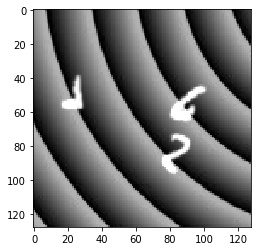

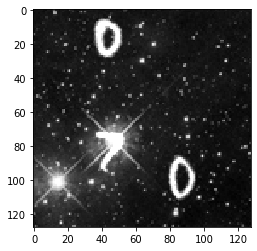

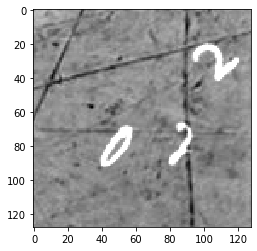

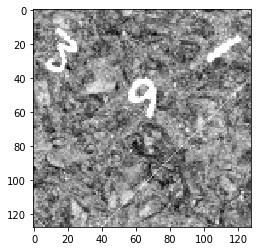

In [5]:
for i in range(4): 
    plt.figure()
    plt.imshow(train_images[i], cmap='gray')

Note the shapes of our datasets, and examine the labels as well. 



In [6]:
# Examine the shapes of our data 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 
print("Shape of our labels: ", train_labels.shape) 
print("Unique labels: ", LABELS)


Shape of training set:  (50000, 128, 128)
Shape of test set:  (10000, 128, 128)
Shape of our labels:  (50000,)
Unique labels:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 2.3 Data Preprocessing 

Although some solid preprocessing work has already been done on these images, we still need to do a couple of things. 

1. We will reshape the data to a format tha the model can understand: (num_datapoints, dim1, dim2, channel)
2. We will further split the dataset in order to have some validation . This will also randomize the data. 
3. We will normalize the data to have values between 0 and 1. This will make a huge impact weh training. 

In [39]:
# Reshaping the images  
train_images = np.reshape( train_images, (50000, 128, 128, 1)) 
test_images = np.reshape( test_images, (10000, 128, 128, 1)) 
print("Shape of training set: ", train_images.shape) 
print("Shape of test set: ", test_images.shape) 

Shape of training set:  (50000, 128, 128, 1)
Shape of test set:  (10000, 128, 128, 1)


In [0]:
# further split into training and testing data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(train_images, train_labels, 
                                                                    test_size=.1, 
                                                                    random_state=42)

# normalize images 
X_train_new = X_train_new / 255.0 
X_test_new = X_test_new / 255.0

# convert to tensors 
X_train_new = tf.convert_to_tensor(X_train_new, dtype=tf.float32)
X_test_new = tf.convert_to_tensor(X_test_new, dtype=tf.float32)
y_train_new = tf.keras.utils.to_categorical(y_train_new, num_classes=10)
y_test_new = tf.keras.utils.to_categorical(y_test_new, num_classes=10)

In [41]:
# Note that the classes have been one-ncoded to categorical
print(y_train_new[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 3. Loading the model: Resnet50 



In [0]:
# obtain respective dimensions 
img_height, img_width = train_images.shape[1], train_images.shape[2] 
num_classes = 10  

base_model = applications.resnet50.ResNet50(weights=None, include_top=False, 
                                           input_shape=(img_height, img_width, 1))

**Note**: Messing up with the "Dropout" parameter affects converge speed hugely. 

In [59]:
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.6)(x) 
predictions = Dense(num_classes, activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs= predictions)

In [60]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary() 

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [61]:
history = model.fit(X_train_new, y_train_new, 
                    validation_data=(X_test_new, y_test_new), 
                    epochs = 5, batch_size = 128)

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 322s 7ms/sample - loss: 0.1944 - accuracy: 0.9464 - val_loss: 0.5040 - val_accuracy: 0.8866
Epoch 2/5
45000/45000 [==============================] - 310s 7ms/sample - loss: 0.1309 - accuracy: 0.9638 - val_loss: 0.3002 - val_accuracy: 0.9180
Epoch 3/5
45000/45000 [==============================] - 311s 7ms/sample - loss: 0.1106 - accuracy: 0.9694 - val_loss: 0.5639 - val_accuracy: 0.8768
Epoch 4/5
45000/45000 [==============================] - 311s 7ms/sample - loss: 0.0946 - accuracy: 0.9734 - val_loss: 0.4595 - val_accuracy: 0.8954
Epoch 5/5
45000/45000 [==============================] - 311s 7ms/sample - loss: 0.0843 - accuracy: 0.9763 - val_loss: 0.2262 - val_accuracy: 0.9480


## 4. Evaluating the model 

In [57]:
preds = model.evaluate(X_test_new, y_test_new)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

A more detailed report 

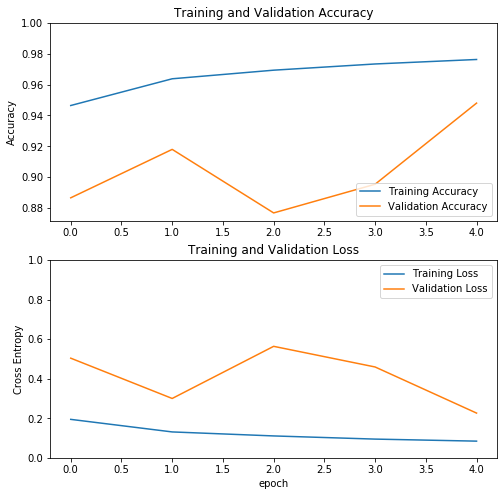

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()